# Stiff ODEs and implicit methods
In this notebook we look at examples where Runge-Kutta methods require very small steps to be accurate. For these **stiff** ODEs implicit methods are better.

Let's define our explicit methods first.

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (15,10)

In [118]:
def EulerStep(f, dx, xi, yi):
    return yi + dx*f(xi, yi)

In [119]:
def RK2Step(f, dx, xi, yi):
    k1 = dx*f(xi, yi)
    k2 = dx*f(xi + dx, yi + k1)
    
    return yi + 0.5*(k1 + k2)

In [120]:
def RK4Step(f, dx, xi, yi):
        k1 = dx*f(xi,yi)
        k2 = dx*f(xi + 0.5*dx, yi + 0.5*k1)
        k3 = dx*f(xi + 0.5*dx, yi + 0.5*k2)
        k4 = dx*f(xi + dx, yi + k3)
        
        return yi + 1/6*(k1 + 2*k2 + 2*k3 + k4)

In [121]:
def ODESolve(f, dx, x0, y0, imax, method='RK4', plotSteps=False):
    
    xi = x0
    yi = y0
    
    # Create arrays to store the steps in
    steps = np.zeros((imax+1,2))
    steps[0,0] = x0
    steps[0,1] = y0
    
    i = 0
    while i < imax:
        if(method == 'RK4'):
            yi = RK4Step(f, dx, xi, yi)
        elif(method == 'RK2'):
            yi = RK2Step(f, dx, xi, yi)
        elif(method == 'Euler'):
            yi = EulerStep(f, dx, xi, yi)
        
        xi += dx
        i  += 1
        
        # Store the steps for plotting
        steps[i, 0] = xi
        steps[i, 1] = yi  
        
    if(plotSteps):
        plt.scatter(steps[:,0], steps[:,1], color='red', linewidth='10')
        
    return [xi, yi]

# Stiff ODEs

Let's look at an example. Consider the *first-order* ODE: 

$$ y'(x) = \lambda[-y(x) + \sin(x)] $$ 

with *initial conditions* $y(0) = 0$. This has the general solution of 

$$ y(x) = C e^{-\lambda x} + \frac{\lambda^2 \sin(x) - \lambda \cos(x)}{1 + \lambda^2}$$ 

The initial condition gives 

$$ C = \frac{\lambda}{1 + \lambda^2}$$

Let's define these equations and see how our RK methods do at solving the ODE. Try using the 'Euler', 'RK2' and 'RK4' methods below.

In [ ]:
lam = 30

def dydxStiff(x,y):
    global lam
    return lam*(-y + np.sin(x))

def yStiff(x):
    global lam
    C = lam/(1+lam**2)
    return C*np.exp(-lam*x) + (lam**2*np.sin(x) -lam*np.cos(x))/(1+lam**2)

[0.9999999999999999, 1.5906729807959397]

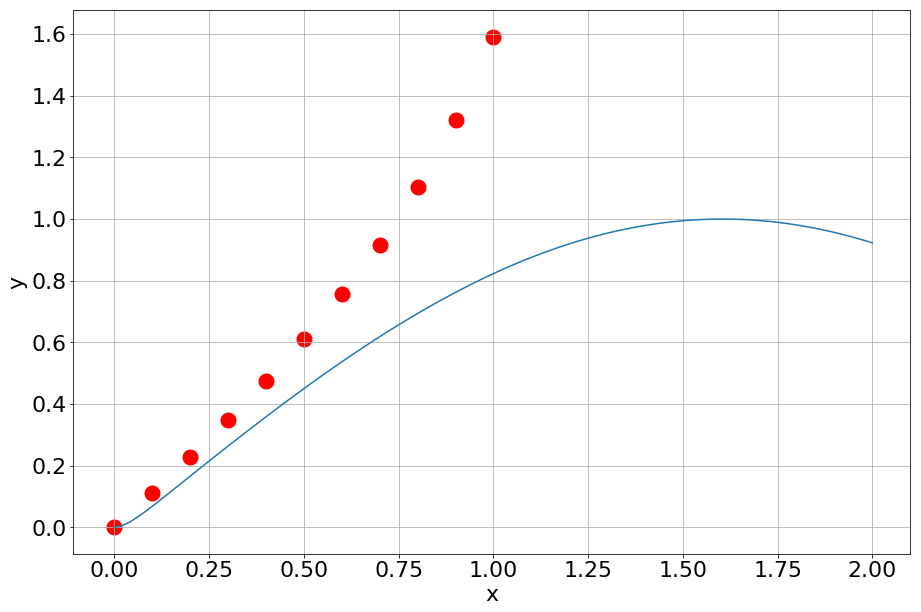

In [164]:
x = np.linspace(0, 2.0, 100)
y = yExact(x)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.plot(x,y)


ODESolve(dydx, 0.1, 0, 0, 10, 'RK4', True)

We see that even the more accurate RK4 method does not do well. It can be made to perform better by decreasing the step size but we want to avoid this. Furthermore, if we increase $\lambda$ the step size required to accurately obtain the solution drops rapidly.

To overcome this, let's look at implicit methods. One of the simplest is the Backwards Euler method.

## Implicit method: backwards Euler

The backwards Euler method is given by:

$$ \begin{align} 
    x_{i+1} &= x_i + \Delta x \\
    y_{i+1} &= y_i + \Delta x f(x_{i+1}, y_{i+1}) \\
    \end{align}
    $$
    
Notice how, unlike the *explicit* methods we've looked at until now this does not immediately give a recipe for the next step in terms of the previous steps. We must solve the second equation for $y_{i+1}$. In general we won't be able to find an analytic solution, so we might use *numerical root finding*.

Let's look at the stiff ODE example given above, where it turns out we can find an analytic solution. In this case we have:

$$ \begin{align}
    x_{i+1} &= x_i + \Delta x \\
    y_{i+1} &= y_i + \Delta x \lambda[-y_{i+1} + \sin(x_{i+1})]
\end{align}$$

In this case we can solve the second equation explicitly for $y_{i+1}$:

$$ y_{i+1} = \frac{y_i + \Delta x \lambda \sin(x_{i+1})}{1 + \Delta x \lambda}$$

Let's now implement this *specific* example in code and test it out.

In [159]:
def BackwardsEulerSpecific(f, dx, x0, y0, imax, plotSteps=False):
    global lam
    
    xi = x0
    yi = y0
    
    # Create arrays to store the steps in
    steps = np.zeros((imax+1,2))
    steps[0,0] = x0
    steps[0,1] = y0
    
    i = 0
    while i < imax:
        yi = (yi + dx * lam*np.sin(xi+dx))/(1+ dx*lam)
        xi += dx
        i += 1
        
        # Store the steps for plotting
        steps[i, 0] = xi
        steps[i, 1] = yi  
    
    if(plotSteps):
        plt.scatter(steps[:,0], steps[:,1], color='green', linewidth='10')
        
    return [xi, yi]

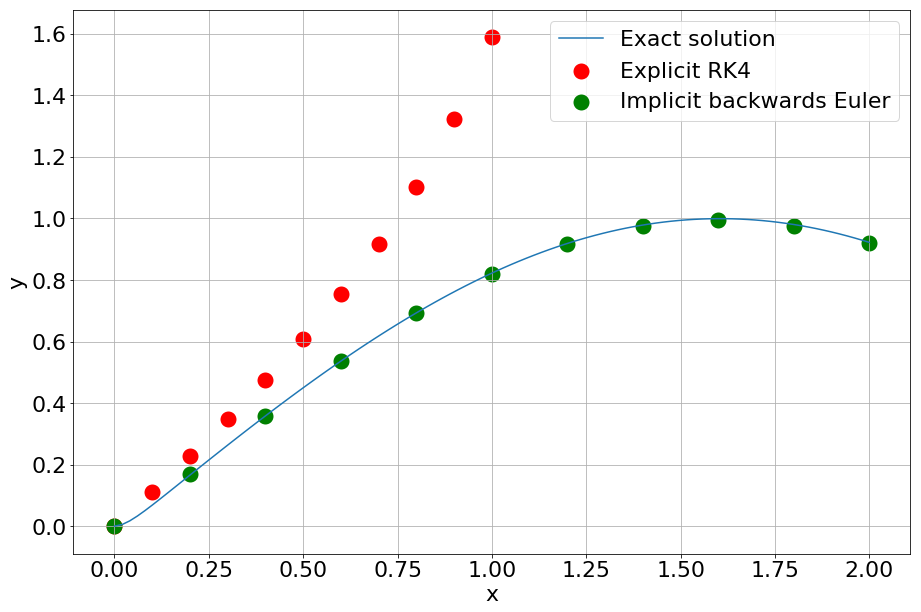

In [172]:
x = np.linspace(0, 2.0, 100)
y = yExact(x)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.plot(x,y)

ODESolve(dydx, 0.1, 0, 0, 10, 'RK4', True)

BackwardsEulerSpecific(dydx, 0.2, 0, 0, 10, True)

plt.legend(['Exact solution', 'Explicit RK4', 'Implicit backwards Euler'])

We can thus see that the (implicit) backwards Euler method is much more successful than the (explicit) RK4 method, even when it takes larger steps. This is great because each step of the RK4 method is more expensive than a step of the Euler method. The downside to implicit methods can be seen from the code above: our implicit ODE solver code is not general, it only works for this specific example. In general, implicit methods are more complicated to implement as they often require numerical methods, e.g., root finding to find $y_{i+1}$.

Note, unlike the forward Euler method, the backwards Euler method is stable across a much wider class of ODEs.